In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from f1tenth_gym_jax import make
import jax
import jax.numpy as jnp

# jax.config.update("jax_debug_nans", True)

from f1tenth_gym_jax.envs.utils import Param

In [2]:
num_agents = 10
num_envs = 100

In [3]:
env = make(f"Spielberg_{num_agents}_scan_time_v0")

In [4]:
rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
reset_rng = jax.random.split(_rng, num_envs)

In [5]:
import chex
chex.clear_trace_counter()

In [6]:
obsv, env_state = jax.vmap(env.reset)(reset_rng)

/home/billyzheng/.cache/pypoetry/virtualenvs/f1tenth-gym-jax-3S11c-Oo-py3.13/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/billyzheng/.cache/pypoetry/virtualenvs/f1tenth-gym-jax-3S11c-Oo-py3.13/lib/python3.13/site-packages/jax/_src/numpy/array_creation.py:532: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  delta: Array = lax.convert_element_type(s

In [7]:
rng, _rng = jax.random.split(rng)
action_rng = jax.random.split(_rng, num_envs*num_agents).reshape((num_agents, num_envs, -1))
actions = {k: jax.vmap(env.action_space(k).sample)(action_rng[i]) for i, k in enumerate(env.agents)}

In [8]:
rng, _rng = jax.random.split(rng)
step_rng = jax.random.split(_rng, num_envs)
obsv, env_state, _, _, info = jax.vmap(env.step)(step_rng, env_state, actions)

In [9]:
def env_init(rng):
    rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, num_envs)
    obsv, env_state = jax.vmap(env.reset)(reset_rng)
    return (env_state, obsv, rng)

In [ ]:
def env_step(runner_state, unused):
    env_state, last_obs, rng = runner_state

    rng, _rng = jax.random.split(rng)
    action_rng = jax.random.split(_rng, num_envs*num_agents).reshape((num_agents, num_envs, -1))
    actions = {k: jax.vmap(env.action_space(k).sample)(action_rng[i]) for i, k in enumerate(env.agents)}

    rng, _rng = jax.random.split(rng)
    step_rng = jax.random.split(_rng, num_envs)
    obsv, env_state, _, _, info = jax.vmap(env.step)(step_rng, env_state, actions)

    runner_state = (env_state, obsv, rng)
    return runner_state, env_state

In [11]:
import time

In [18]:
tick = time.time()
for _ in range(100):
    runner_state = env_init(rng)
    runner_state, all_env_states = jax.lax.scan(env_step, runner_state, None, length=100)
tock = time.time()

In [19]:
sps = 100 * 100 * num_envs / (tock - tick)

In [20]:
sps

21426.164899802825

In [21]:
all_env_states.cartesian_states.shape

(100, 100, 10, 7)

In [22]:
all_env_states.cartesian_states[:, 100, 0, :]

Array([[-4.51608696e+01,  5.96198368e+00, -2.24437881e-02,
         6.76888460e-03, -1.53370570e-06, -4.71457344e-04,
        -1.16549339e-02],
       [-4.51607780e+01,  5.96198177e+00, -5.44437915e-02,
         1.12162493e-02, -1.23664749e-05, -1.86176633e-03,
        -2.82893069e-02],
       [-4.51607323e+01,  5.96198034e+00, -5.56205027e-02,
        -3.87401599e-03, -1.98128364e-05,  6.38730708e-04,
        -2.89016441e-02],
       [-4.51605072e+01,  5.96197605e+00, -2.50002220e-02,
         4.69935238e-02, -4.35767033e-05, -3.49719264e-03,
        -1.29828602e-02],
       [-4.51597404e+01,  5.96196556e+00, -2.68929899e-02,
         1.05998412e-01, -1.03976068e-04, -8.57299287e-03,
        -1.39661264e-02],
       [-4.51582680e+01,  5.96194124e+00, -3.51854749e-02,
         1.88291922e-01, -2.44044626e-04, -2.00077165e-02,
        -1.82748884e-02],
       [-4.51559792e+01,  5.96191883e+00, -3.18547338e-03,
         2.69369453e-01, -3.70468129e-04, -2.53739767e-03,
        -1.6539972

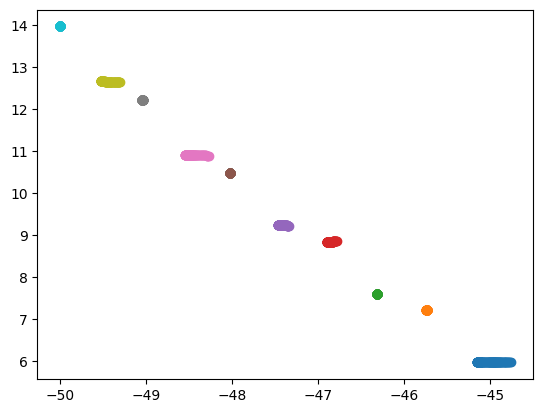

In [23]:
import matplotlib.pyplot as plt
for i in range(num_agents):
    plt.plot(all_env_states.cartesian_states[:, 100, i, 0], all_env_states.cartesian_states[:, 100, i, 1], 'o')

In [24]:
all_env_states.scans.shape

(100, 100, 10, 64)

In [39]:
scan = all_env_states.scans[0, 0, 0, :]
scan_angles = jnp.linspace(-env.fov/2, env.fov/2, num=scan.shape[0], endpoint=True)

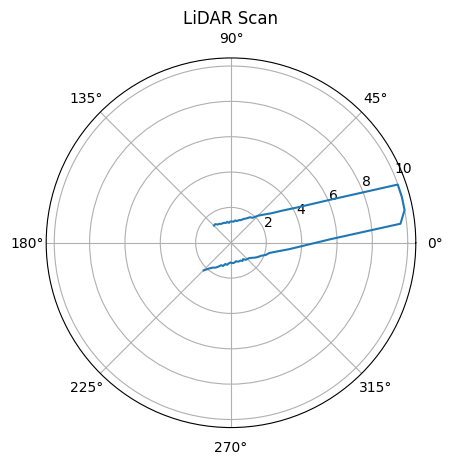

In [42]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(scan_angles, scan)
ax.set_title('LiDAR Scan')
plt.show()

In [44]:
runner_state[1]["agent_0"].shape

(100, 107)

In [46]:
runner_state[1]["agent_0"][:, [0, 1, 4]].shape

(100, 3)

In [56]:
jnp.vstack((env.track.raceline.xs, env.track.raceline.ys)).T.shape

(1692, 2)